# Importing

In [1]:
## Importing Packages
import math
import nltk
import random
import pickle
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import os
import email
import torch
import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, LSTM, Dense, Bidirectional
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
import nltk
import re
from transformers import BertTokenizer
import pickle
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator


In [2]:
## Checking for GPU Access
!nvidia-smi

/bin/bash: line 1: nvidia-smi: command not found


In [3]:
from google.colab import drive
drive.mount('/content/drive')
!cp '/content/drive/MyDrive/kaggle.json' '/content'

Mounted at /content/drive


# Dataset download

In [ ]:
import zipfile
import os
os.environ['KAGGLE_CONFIG_DIR'] = "/content"
!kaggle datasets download -d crmercado/tweets-blogs-news-swiftkey-dataset-4million
zip_ref = zipfile.ZipFile('tweets-blogs-news-swiftkey-dataset-4million.zip', 'r')
zip_ref.extractall('/content/tmp')
zip_ref.close()

Dataset URL: https://www.kaggle.com/datasets/crmercado/tweets-blogs-news-swiftkey-dataset-4million
License(s): CC0-1.0
tweets-blogs-news-swiftkey-dataset-4million.zip: Skipping, found more recently modified local copy (use --force to force download)


In [ ]:
## Basic File Paths
data_dir = "/content/tmp/final/en_US"
# file_path1 = data_dir + "/en_US.twitter.txt"
file_path = data_dir + "/en_US.blogs.txt"


## nltk settings
nltk.data.path.append(data_dir)
nltk.download('punkt')

## Opening the File in read mode ("r")
with open(file_path, "r") as f:
    data = f.read()


In [ ]:
data=data[:400000]

In [ ]:
data[400000:400980]

# Cleaning Text

In [ ]:
# Function to remove emojis and special characters from text
def remove_emojis_and_special_characters(text):
    # Remove emojis
    emoji_pattern = re.compile("["
                               u"\U0001F600-\U0001F64F"  # emoticons
                               u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                               u"\U0001F680-\U0001F6FF"  # transport & map symbols
                               u"\U0001F700-\U0001F77F"  # alchemical symbols
                               u"\U0001F780-\U0001F7FF"  # Geometric Shapes Extended
                               u"\U0001F800-\U0001F8FF"  # Supplemental Arrows-C
                               u"\U0001F900-\U0001F9FF"  # Supplemental Symbols and Pictographs
                               u"\U0001FA00-\U0001FA6F"  # Chess Symbols
                               u"\U0001FA70-\U0001FAFF"  # Symbols and Pictographs Extended-A
                               u"\U00002702-\U000027B0"  # Dingbats
                               u"\U000024C2-\U0001F251"
                               "]+", flags=re.UNICODE)

    # Remove special characters
    text = re.sub(r'[^a-zA-Z0-9\s]', '', text)

    # Remove extra spaces
    text = re.sub(' +', ' ', text)

    return text

In [ ]:
# Preprocessing pipeline
def preprocess_pipeline(data) -> 'list':
    # Split by newline character
    sentences = data.split('\n')
    for i in range(len(sentences)):
        sentences[i] = remove_emojis_and_special_characters(sentences[i])
    # Remove leading and trailing spaces
    sentences = [s.strip() for s in sentences]
    # Drop empty sentences
    sentences = [s for s in sentences if len(s) > 0]
    # Tokenization
    tokenized = []
    for sentence in sentences:
        # Convert to lowercase
        sentence = sentence.lower()
        tokenized.append(sentence)
    return tokenized

# Tokenize sentences
tokenized_sentences = preprocess_pipeline(data)

In [ ]:
tokenized_sentences[:2]

In [ ]:
# Tokenize words
tokenizer = Tokenizer(oov_token='<oov>')
tokenizer.fit_on_texts(tokenized_sentences)
# Save the tokenizer
with open('/content/drive/MyDrive/Text-Auto-complete/tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
with open('/content/drive/MyDrive/Text-Auto-complete/tokenizer.pickle', 'rb') as handle:
    tokenizer = pickle.load(handle)
total_words = len(tokenizer.word_index) + 1
total_words

In [ ]:
# Generate n-gram input sequences
input_sequences = []
for line in tokenized_sentences:
    token_list = tokenizer.texts_to_sequences([line])[0]
    for i in range(1, len(token_list)):
        n_gram_sequence = token_list[:i + 1]
        input_sequences.append(n_gram_sequence)

# Pad sequences
max_sequence_len = max([len(x) for x in input_sequences])
input_sequences = np.array(pad_sequences(input_sequences, maxlen=max_sequence_len, padding='pre'))

# Train-Test Split

In [ ]:
# Creates labels with input sequences
X,labels = input_sequences[:,:-1],input_sequences[:,-1]
ys = tf.keras.utils.to_categorical(labels, num_classes=total_words)

In [ ]:
# Split data into training, validation, and test sets
from sklearn.model_selection import train_test_split
X_train_temp, X_val_test, y_train_temp, y_val_test = train_test_split(X, ys, test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_val_test, y_val_test, test_size=0.5, random_state=42)

# Train LSTM Model

In [16]:
# Create and compile the model
# model = Sequential()
# model.add(Embedding(total_words, 100))
# model.add(Bidirectional(LSTM(150)))
# model.add(Dense(total_words, activation='softmax'))

model = tf.keras.models.load_model('/content/drive/MyDrive/Text-Auto-complete/txt-autocomplete-model.h5')

adam = Adam(learning_rate=0.01)
model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])


history = model.fit(X_train_temp, y_train_temp, epochs=20, validation_data=(X_val, y_val), verbose=1)
model.save('/content/drive/MyDrive/Text-Auto-complete/txt-autocomplete-model.h5')

Epoch 1/20
1752/1752 [==============================] - 155s 85ms/step - loss: 2.8646 - accuracy: 0.4081 - val_loss: 18.9511 - val_accuracy: 0.0515
Epoch 2/20
1752/1752 [==============================] - 87s 49ms/step - loss: 2.6730 - accuracy: 0.4248 - val_loss: 19.2018 - val_accuracy: 0.0517
Epoch 3/20
1752/1752 [==============================] - 85s 48ms/step - loss: 2.6113 - accuracy: 0.4348 - val_loss: 19.3674 - val_accuracy: 0.0531
Epoch 4/20
1752/1752 [==============================] - 79s 45ms/step - loss: 2.5910 - accuracy: 0.4367 - val_loss: 19.3812 - val_accuracy: 0.0562
Epoch 5/20
1752/1752 [==============================] - 79s 45ms/step - loss: 2.5973 - accuracy: 0.4363 - val_loss: 19.4526 - val_accuracy: 0.0547
Epoch 6/20
1752/1752 [==============================] - 80s 45ms/step - loss: 2.5797 - accuracy: 0.4412 - val_loss: 19.5793 - val_accuracy: 0.0564
Epoch 7/20
1752/1752 [==============================] - 79s 45ms/step - loss: 2.5800 - accuracy: 0.4381 - val_loss: 1

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [17]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

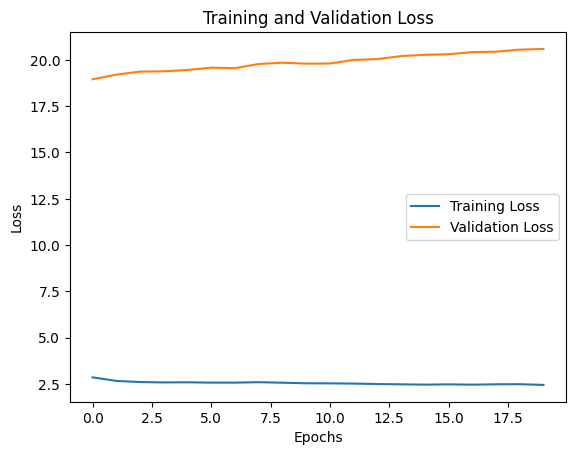

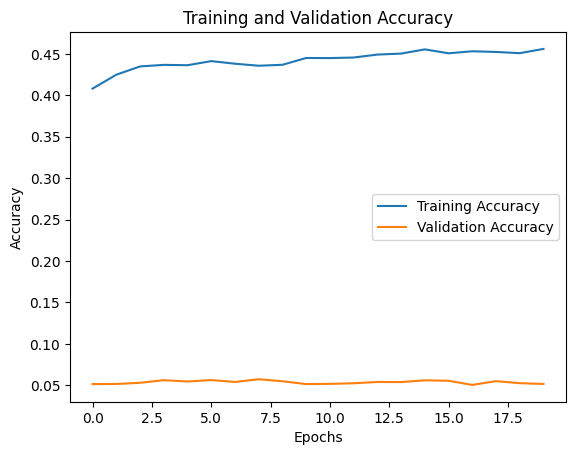

In [18]:
# Plot Loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot Accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Inferences

In [ ]:
model = tf.keras.models.load_model('/content/drive/MyDrive/Text-Auto-complete/txt-autocomplete-model.h5')

In [ ]:
def predict_top_five_words(model, tokenizer, seed_text):
    token_list = tokenizer.texts_to_sequences([seed_text])[0]
    token_list = pad_sequences([token_list], maxlen=max_sequence_len-1, padding='pre')
    predicted = model.predict(token_list, verbose=0)
    top_five_indexes = np.argsort(predicted[0])[::-1][:5]
    top_five_words = []
    for index in top_five_indexes:
        for word, idx in tokenizer.word_index.items():
            if idx == index:
                top_five_words.append(word)
                break
    return top_five_words

In [35]:
# Test the function
seed_text = "the culprit was caught by"
predict_top_five_words(model, tokenizer, seed_text)

['guest', 'corrupt', 'cat', 'the', 'force']

In [ ]:
# Test the function
seed_text = "they found"
predict_top_five_words(model, tokenizer, seed_text)

In [27]:
# Test the function
seed_text = "Little children wants"
predict_top_five_words(model, tokenizer, seed_text)

['to', 'us', 'that', 'and', 'from']

In [ ]:
seed_text = "implementation of"
next_words = 2

for _ in range(next_words):
    token_list = tokenizer.texts_to_sequences([seed_text])[0]
    token_list = pad_sequences([token_list], maxlen=max_sequence_len-1, padding='pre')
    predicted = model.predict_classes(token_list, verbose=0)
    output_word = ""
    for word, index in tokenizer.word_index.items():
        if index == predicted:
            output_word = word
            break
    seed_text += " " + output_word
print(seed_text)